In [438]:
import tensorflow as tf
import matplotlib.pyplot as plt
#from keras.engine.topology import Layer

In [439]:
PATH = './horse2zebra/'
BUFFER_SIZE = 1000
EPOCHS = 2

In [440]:
def normalize(input_image):
  input_image = (input_image / 127.5) - 1

  return input_image

In [441]:
def load_img(img_file):
    img = tf.io.read_file(img_file)
    img = tf.image.decode_jpeg(img)
    img = tf.cast(img, tf.float32) # <-- 중요
    img = normalize(img)
    
    return img

In [442]:
print(PATH)

./horse2zebra/


In [443]:
img1 = load_img(PATH+'/trainA/n02381460_2.jpg')

NotFoundError: ./horse2zebra//trainA/n02381460_2.jpg; No such file or directory [Op:ReadFile]

W0623 14:21:25.019649 4714849728 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


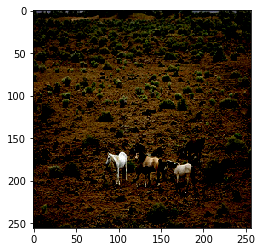

In [444]:
plt.imshow(img1)

In [445]:
img1.shape

TensorShape([256, 256, 3])

In [446]:
train_dataset = tf.data.Dataset.list_files(PATH+'/trainA/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_img,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)
train_dataset_a = train_dataset

In [447]:
train_dataset_a

<DatasetV1Adapter shapes: (None, None, None, None), types: tf.float32>

In [451]:
train_dataset = tf.data.Dataset.list_files(PATH+'trainB/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_img,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)
train_dataset_b = train_dataset

In [452]:
test_dataset = tf.data.Dataset.list_files(PATH+'testA/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_img)
test_dataset = test_dataset.batch(1)
test_dataset_a = test_dataset

In [453]:
test_dataset = tf.data.Dataset.list_files(PATH+'testB/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_img)
test_dataset = test_dataset.batch(1)
test_dataset_b = test_dataset

In [454]:
# ^_________ ??
# prepared traindataset_a & traindataset_b & testdataset_a & testdataset_b

In [455]:
train_dataset_b

<DatasetV1Adapter shapes: (None, None, None, None), types: tf.float32>

# Build the Generator

In [456]:
def downsample(filters, size, stride, applybatchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if applybatchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    #result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [457]:
def upsample(filters, size, stride, applybatchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=stride, padding='same',
                                              kernel_initializer=initializer, use_bias=False))
    if applybatchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [458]:
# Define the residual block as a new layer
class res_block(tf.keras.layers.Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(res_block, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, inputs):
        # the residual block using Keras functional API
        first_layer =   tf.keras.layers.Activation("linear", trainable=False)(inputs)
        x = tf.keras.layers.Conv2D( self.channels_in, self.kernel, padding="same")(first_layer)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2D( self.channels_in, self.kernel, padding="same")(x)
        residual = tf.keras.layers.Add()([x, first_layer])
        last = tf.keras.layers.Activation("relu")(residual)
        return last

    def compute_output_shape(self, input_shape):
        return input_shape

In [459]:
def residual_block(filters):
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters, size, stride=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    result.add(tf.keras.layers.Conv2D(filters, size, stride=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    
    return result

In [460]:
test1 = downsample(10,2,1)
test2 = test1(img2)
test2.shape

TensorShape([1, 256, 256, 10])

In [461]:
def gen_XtoY():
    
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    
    stack = [
        downsample(64,7,1), #(none,256,256,64)
        downsample(128,3,2), #(..,128,128,128)
        downsample(256,3,2), #(...,64,64,256)
        res_block(256,(3,3)),
        res_block(256,(3,3)),
        res_block(256,(3,3)),
        res_block(256,(3,3)),
        res_block(256,(3,3)),
        res_block(256,(3,3)),
        upsample(128,3,2), #(...128,128,128)
        upsample(64,3,2), #(...,258.258,64)
        downsample(3,7,1), #(..,,)
    ]
    
    for i in stack:
        x = i(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

W0623 14:22:34.544095 4714849728 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_301 (Sequential)  (None, None, None, 64)    9664      
_________________________________________________________________
sequential_302 (Sequential)  (None, None, None, 128)   74240     
_________________________________________________________________
sequential_303 (Sequential)  (None, None, None, 256)   295936    
_________________________________________________________________
sequential_304 (Sequential)  (None, None, None, 128)   295424    
_________________________________________________________________
sequential_305 (Sequential)  (None, None, None, 64)    73984     
_________________________________________________________________
sequential_306 (Sequential)  (None, None, None, 3)     942

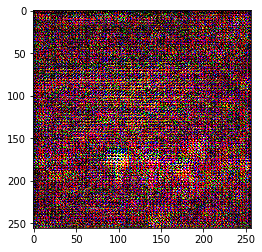

In [462]:

generator = gen_XtoY()

gen_output = generator(img1[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...]*1000) #<--?

generator.summary()

# Build the Discriminator

In [491]:
def disc_X():
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    
    stack = [
        downsample(64,4,2),
        downsample(128,4,2),
        downsample(256,4,2),
        downsample(512,4,2),
        downsample(1,4,1),
    ]
    
    for i in stack:
        x = i(x)
        
    x = tf.keras.activations.sigmoid(x)
        
    return tf.keras.Model(inputs=inputs, outputs=x)

In [492]:
gen_AtoB = gen_XtoY()
gen_BtoA = gen_XtoY()
disc_A = disc_X()
disc_B = disc_X()

In [493]:
disc_A.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_341 (Sequential)  (None, None, None, 64)    3328      
_________________________________________________________________
sequential_342 (Sequential)  (None, None, None, 128)   131584    
_________________________________________________________________
sequential_343 (Sequential)  (None, None, None, 256)   525312    
_________________________________________________________________
sequential_344 (Sequential)  (None, None, None, 512)   2099200   
_________________________________________________________________
sequential_345 (Sequential)  (None, None, None, 1)     8196      
Total params: 2,767,620
Trainable params: 2,765,698
Non-trainable params: 1,922
____________________________________________

# Loss function and optimizer

In [510]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [511]:
def generator_loss(A, B, ABA, BAB):
    #cycle_loss_a = loss_object(A, ABA)
    #cycle_loss_b = loss_object(B, BAB)
    
    cycle_loss_a = tf.reduce_mean(tf.abs(A - ABA))
    cycle_loss_b = tf.reduce_mean(tf.abs(B - BAB))
    
    cycle_total_loss = cycle_loss_a + cycle_loss_b
    return cycle_total_loss

In [512]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    disc_total_loss = real_loss + generated_loss

    return disc_total_loss

In [513]:
generator_optimizer_ab = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_optimizer_ba = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_optimizer_a = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer_b = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training

In [514]:
@tf.function
def train_step(img_A, img_B):
    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape(persistent=True) as disc_tape:
        AB = gen_AtoB(img_A, training=True)
        BA = gen_BtoA(img_B, training=True)
        
        ABA = gen_BtoA(AB, training=True)
        BAB = gen_AtoB(BA, training=True)
        
        DA = disc_A(BA, training=True)
        DB = disc_B(AB, training=True)
        
        cycle_total_loss = generator_loss(img_A, img_B, ABA, BAB)

        DX_total_loss = discriminator_loss(img_B, DB)
        DY_total_loss = discriminator_loss(img_A, DA)
        
        total_loss = cycle_total_loss + DX_total_loss + DY_total_loss
        
        AtoB_grad = gen_tape.gradient(total_loss, gen_AtoB.trainable_variables)
        BtoA_grad = gen_tape.gradient(total_loss, gen_BtoA.trainable_variables)
        DA_grad = disc_tape.gradient(total_loss, disc_A.trainable_variables)###
        DB_grad = disc_tape.gradient(total_loss, disc_B.trainable_variables)
        
        generator_optimizer_ab.apply_gradients(zip(AtoB_grad, gen_AtoB.trainable_variables))
        generator_optimizer_ba.apply_gradients(zip(BtoA_grad, gen_BtoA.trainable_variables))
        discriminator_optimizer_a.apply_gradients(zip(DA_grad, disc_A.trainable_variables))
        discriminator_optimizer_b.apply_gradients(zip(DB_grad, disc_B.trainable_variables))
        

In [515]:
def train():
         for epoch in range(EPOCHS):
            for img_A, img_B in tf.data.Dataset.zip((train_dataset_a, train_dataset_b)):
                train_step(img_A, img_B)
            print('epoch : {}'.format(epoch+1))

In [516]:
train()

KeyboardInterrupt: 